In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functools import partial
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

jax.config.update('jax_platform_name', 'cpu')

In [3]:
n_samples = 300     # sampling frequency
period = 10

harmonic_coefficients = jnp.array([
    #harmoic, amplitude
    [0.5,   0.6],
    [1,         1],
    [1.5,   0.5],
    [2,     3],
    [2.5,   0.4],
    [3,     0.8],
    [4,     0.8],
])

ts = jnp.linspace(0, period, n_samples)

signal = sum([amplitude*jnp.sin(2.0 * jnp.pi * harmonic * ts)
              for harmonic, amplitude in harmonic_coefficients])
print(signal.shape)

(300,)


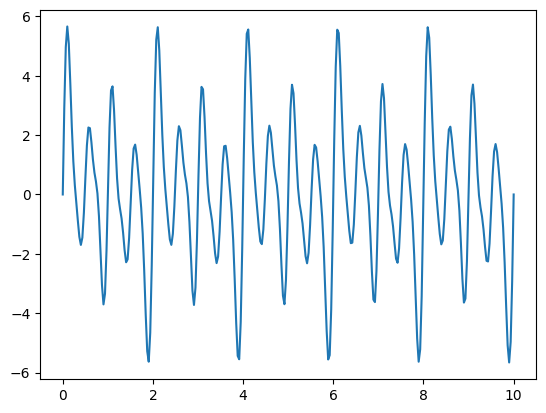

In [4]:
plt.plot(ts, signal)

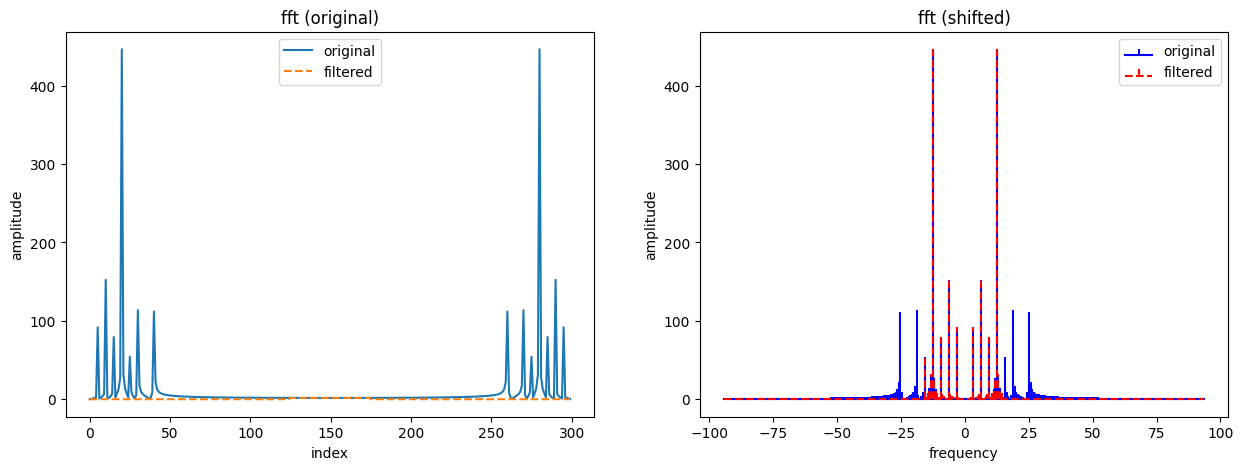

In [6]:
num_samples = signal.shape[0]
freqs = jnp.fft.fftfreq(num_samples, d=period/(2.0*jnp.pi*n_samples))
freqs_shifted = jnp.fft.fftshift(freqs)
signal_spectrum = jnp.fft.fft(signal, n=num_samples)
signal_spectrum_shifted = jnp.fft.fftshift(signal_spectrum)

low_pass_filter = jnp.zeros(signal_spectrum.shape[0])
num_freqs_pass = 50
low_pass_filter = low_pass_filter.at[(num_samples-num_freqs_pass)//2:(num_samples+num_freqs_pass)//2].set(1.0)
signal_spectrum_filted = signal_spectrum * low_pass_filter
signal_spectrum_shifted_filted = signal_spectrum_shifted * low_pass_filter

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(jnp.abs(signal_spectrum), label='original')
plt.plot(jnp.abs(signal_spectrum_filted), label='filtered', linestyle='--')
plt.xlabel('index')
plt.ylabel('amplitude')
plt.title('fft (original)')
plt.legend()
plt.subplot(1, 2, 2)
plt.stem(freqs_shifted, jnp.abs(signal_spectrum_shifted), label='original', linefmt='-b', markerfmt=' ', basefmt='-b')
plt.stem(freqs_shifted, jnp.abs(signal_spectrum_shifted_filted), label='filtered', linefmt='--r', markerfmt=' ', basefmt='--r')
# plt.scatter(harmonic_coefficients[:, 0]*2.0*jnp.pi, harmonic_coefficients[:, 1])
plt.xlabel('frequency')
# plt.xlim(-30, 30)
plt.ylabel('amplitude')
plt.title('fft (shifted)')
plt.legend()

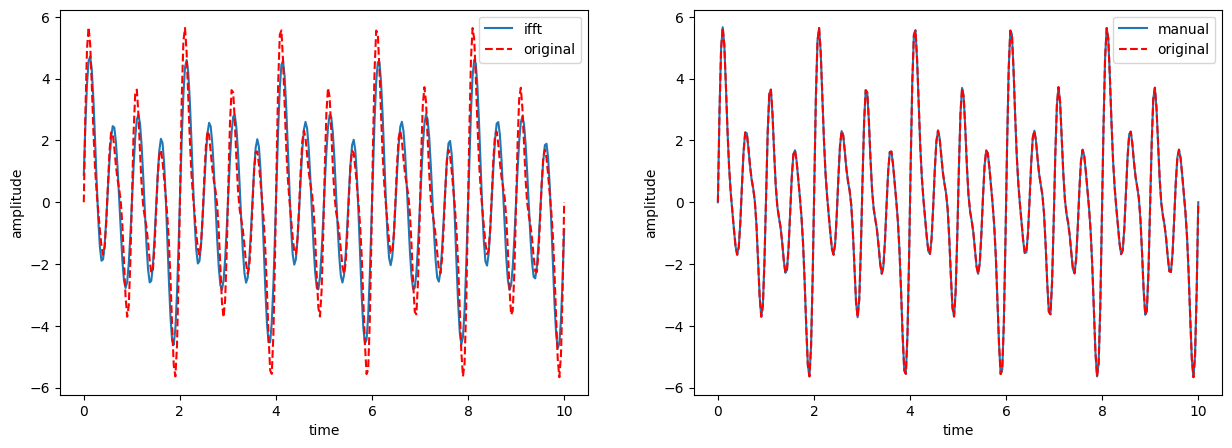

In [36]:
signal_rec_ifft = jnp.fft.ifft(jnp.fft.ifftshift(signal_spectrum_shifted_filted), n=num_samples)

fourier_base = lambda freq: jnp.exp(2.0j * jnp.pi * jnp.linspace(0.0, 1.0, num_samples, endpoint=False) * freq)
freqs = jnp.arange(num_samples)
fourier_basis = jax.vmap(fourier_base)(freqs)
signal_rec_manual = jnp.matmul(fourier_basis, signal_spectrum) / num_samples

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(ts, signal_rec_ifft.real, label='ifft')
plt.plot(ts, signal, label='original', color='red', linestyle='--')
plt.xlabel('time')
plt.ylabel('amplitude')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(ts, signal_rec_manual.real, label='manual')
plt.plot(ts, signal, label='original', color='red', linestyle='--')
plt.xlabel('time')
plt.ylabel('amplitude')
plt.legend()

(50,)


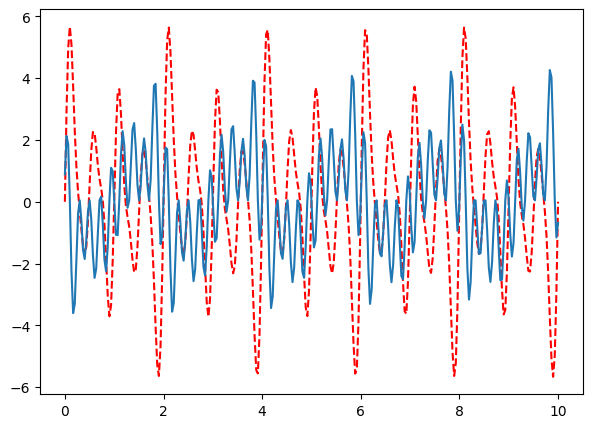

In [37]:
signal_spectrum_shifted_trunc = signal_spectrum_shifted[(num_samples-num_freqs_pass)//2:(num_samples+num_freqs_pass)//2]
print(signal_spectrum_shifted_trunc.shape)
signal_rec_ifft_trunc = jnp.fft.ifft(signal_spectrum_shifted_trunc, n=num_samples)
plt.figure(figsize=(7, 5))
plt.plot(ts, signal, label='original', color='red', linestyle='--')
plt.plot(ts, signal_rec_ifft_trunc.real, label='ifft truncated')

In [38]:
import sys
sys.path.append('../../')

from sdebridge.data_processing import butterfly_amasina_pts

btf_pts shape: (120, 2)
btf_pts_eval_manual shape: (30, 2)


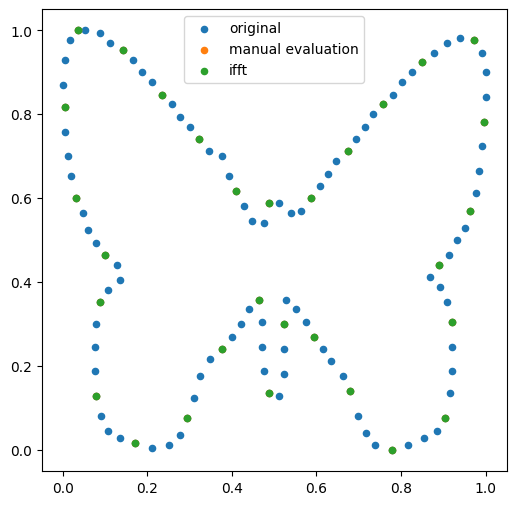

In [57]:
btf_pts = jnp.array(butterfly_amasina_pts())[:, ::200].transpose()
print("btf_pts shape:", btf_pts.shape)
n_samples = btf_pts.shape[0]
n_bases = n_samples // 4

btf_coeffs = jnp.fft.fft(btf_pts, n=n_samples, axis=0, norm='forward')
btf_coeffs_shifted = jnp.fft.fftshift(btf_coeffs, axes=0)
fourier_base = lambda freq: jnp.exp(2.0j * jnp.pi * jnp.arange(n_samples) / n_bases * freq)
freqs = jnp.arange(n_bases)
fourier_basis = jax.vmap(fourier_base)(freqs)
btf_pts_eval_manual = jnp.matmul(fourier_basis, btf_coeffs).real
print("btf_pts_eval_manual shape:", btf_pts_eval_manual.shape)

btf_coeffs_ifft = jnp.fft.ifft(btf_coeffs, n=n_samples, axis=0, norm='forward')[::4, :].real

plt.figure(figsize=(6, 6))
plt.scatter(btf_pts[:, 0], btf_pts[:, 1], s=20, label='original')
plt.scatter(btf_pts_eval_manual[:, 0], btf_pts_eval_manual[:, 1], s=20, label='manual evaluation')
plt.scatter(btf_coeffs_ifft[:, 0], btf_coeffs_ifft[:, 1], s=20, label='ifft')
plt.legend()